<h1> Convolutional Neural Network Model </h1>

-Model EfficientnetV2S with optuna to optimize hyper parameter

-Dataset from kaggle
[Emotion detection](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data?fbclid=IwAR2ANnktL_i9GbHTKObYFc7OIVB5PtPnATzb7zQrMpuCmr1g5uRZT0JGHf0)

In [ ]:
import os

In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
!pip install optuna

In [ ]:
import torch
import torchvision
from torchvision import transforms , models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import optuna
from optuna.trial import TrialState

In [ ]:
train_n_test = '/content/drive/MyDrive/HappySad'
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(train_n_test,transform = transform)
num_class = len(dataset.classes)

In [ ]:
data_size = len(dataset)
val_size = int(0.1*data_size)
test_size = int(0.1*data_size)
train_size = data_size - val_size - test_size

train_data , val_data , test_data = random_split(dataset,[train_size,val_size,test_size])
batch_size = 64

train_loader = DataLoader(train_data,batch_size,shuffle=True)
val_loader = DataLoader(val_data,batch_size,shuffle=True)
test_loader = DataLoader(test_data , batch_size , shuffle = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def accuracy(out,label):
    _,prediction = torch.max(out , dim = 1)
    return torch.tensor(torch.sum(label==prediction).item()/ len(prediction))

def train(train_loader,model,optimizer):
    model.train()
    train_sample = 0
    train_loss = 0
    for batch in train_loader:
        img , label = batch
        img,label = img.to(device) , label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = F.cross_entropy(out,label)
        loss.backward()
        optimizer.step()

        train_sample += 1
        train_loss += loss.item()

    return train_loss / train_sample

def validate(val_loader,model,optimizer):
    model.eval()
    val_sample = 0
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for batch in val_loader:
            img , label = batch
            img,label = img.to(device) , label.to(device)

            out = model(img)
            loss = F.cross_entropy(out,label)
            acc = accuracy(out,label)

            val_loss += loss.item()
            val_acc += acc
            val_sample += 1

    return val_loss/val_sample , val_acc/val_sample

def test(test_loader,model,optimizer,confusion_matrix):
    test_loss = []
    test_acc = []
    test_sample = 0

    with torch.no_grad():
        for batch in test_loader:
            img , label = batch
            img,label = img.to(device) , label.to(device)

            out = model(img)
            _, prediction = torch.max(out, dim=1)
            for i in range(len(prediction)):
                confusion_matrix[label[i]][prediction[i]]+= 1  #x axis predicted , y axis true label

            loss = F.cross_entropy(out,label)
            acc = accuracy(out,label)

            test_loss.append(loss.item())
            test_acc.append(acc)
            test_sample += 1

    return test_loss , test_acc , confusion_matrix

In [ ]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers",1,3)
    layers =[]

    effmodel = models.efficientnet_v2_s(weights = 'DEFAULT')
    in_features = effmodel.classifier[1].out_features
    for i in range(n_layers):
        out_features = trial.suggest_int("n_unit{}".format(i),64,512)
        layers.append(nn.Linear(in_features , out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("droupout{}".format(i),0.2,0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features,num_class))
    layers.append(nn.LogSoftmax(dim=1))

    new_module = nn.Sequential(*layers)
    effmodel.add_module('fc2',module = new_module)

    return effmodel




In [ ]:
def objective(trial):
    model = define_model(trial).to(device)

    optimizer_name = trial.suggest_categorical("optimizer",["Adam","SGD","RMSprop"])
    lr = trial.suggest_float("lr",1e-5,1e-1,log=True)
    optimizer = getattr(optim,optimizer_name)(model.parameters(),lr=lr)

    num_epoch = 5
    total_tloss = []
    total_vloss = []
    total_vacc = []

    sum_vacc = 0
    accuracy = 0
    vloss = 0

#     val_eq = np.array([0,0,0,0,0])

    for epoch in range(num_epoch):

        tloss = train(train_loader,model,optimizer)
        vloss , vacc = validate(val_loader,model,optimizer)
        print("epoch ",epoch,"train_loss" ,tloss, "val_loss",vloss,"val_acc",vacc)
#         total_tloss.append(tloss)
#         total_vloss.append(vloss)
#         total_vacc.append(vacc)
        accuracy = vacc
        sum_vacc += vacc
        trial.report(accuracy,epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return vloss


In [ ]:
# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective,n_trials=20)

# pruned_trials = study.get_trials(deepcopy=False,states = [TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False,states = [TrialState.COMPLETE])

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [ ]:
# Trial 4 finished with value: 0.16775399054351606 and parameters: {'n_layers': 1, 'n_unit0': 239, 'droupout0': 0.389431823413254, 'optimizer': 'RMSprop', 'lr': 0.0002118485076226617}. Best is trial 4 with value: 0.16775399054351606.
model = models.efficientnet_v2_s(weights = 'DEFAULT')
newmodule = nn.Sequential(
    nn.Linear(model.classifier[1].out_features,239),
    nn.ReLU(),
    nn.Dropout(0.389431823413254),
    nn.Linear(239,num_class),
    nn.LogSoftmax(dim=1)
)
model.add_module('fc2',module = newmodule)
model = model.to(device)

# model = models.resnet34()
# model.add_module('fc2',module = nn.Linear(model.fc.out_features , num_class))
# model = model.to(device)

optimizer = optim.RMSprop(model.parameters(),lr = 0.0002118485076226617)

epoch  0 train_loss 0.02524990852007728 val_loss 0.3128045231692101 val_acc tensor(0.9267)
epoch  1 train_loss 0.022411416195130807 val_loss 0.3444142064177676 val_acc tensor(0.9276)
epoch  2 train_loss 0.01593234416520174 val_loss 0.39449368338835866 val_acc tensor(0.9268)
epoch  3 train_loss 0.020471298321162498 val_loss 0.3788568542191857 val_acc tensor(0.9252)
epoch  4 train_loss 0.01892373834389697 val_loss 0.37530440445009033 val_acc tensor(0.9300)
epoch  5 train_loss 0.015647625143174082 val_loss 0.4484665291874032 val_acc tensor(0.9103)
epoch  6 train_loss 0.016630357042614424 val_loss 0.33077238500118256 val_acc tensor(0.9325)


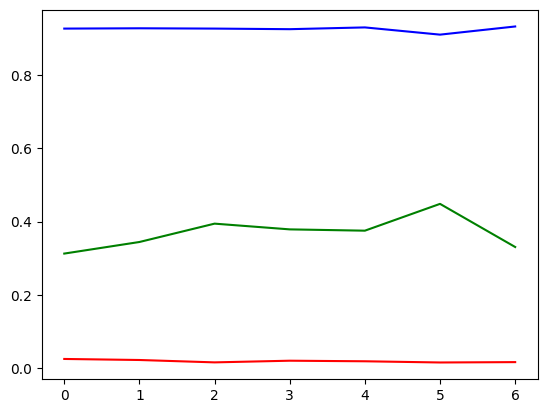

In [ ]:
num_epoch = 30
total_tloss = []
total_vloss = []
total_vacc = []

val_eq = np.array([0,0,0,0,0])

for epoch in range(num_epoch):

    tloss = train(train_loader,model,optimizer)
    vloss , vacc = validate(val_loader,model,optimizer)
    total_tloss.append(tloss)
    total_vloss.append(vloss)
    total_vacc.append(vacc)

    print("epoch ",epoch,"train_loss" ,tloss, "val_loss",vloss,"val_acc",vacc)

    if epoch > 5:
        val_eq[0:3],val_eq[4] = val_eq[1:4],vloss
        if vloss < val_eq[-1]:
            torch.save(model,'/content/drive/MyDrive/emotion_recog_model.pt')
        if np.sum(val_eq[0:3]>val_eq[1:4]) == 0 :
            break
    else:
        val_eq[epoch-1] = vloss

plt.plot(np.arange(len(total_tloss)) , total_tloss,'r')
plt.plot(np.arange(len(total_vloss)) , total_vloss,'g')
plt.plot(np.arange(len(total_vacc)) , total_vacc,'b')

plt.show()

In [ ]:
confusion_matrix = np.zeros((num_class,num_class))

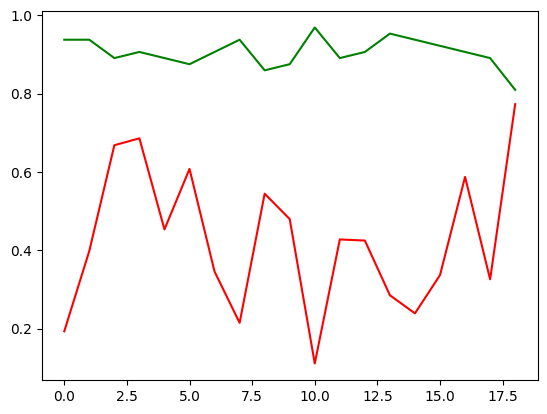

In [ ]:
model2 = torch.load('/content/drive/MyDrive/emotion_recog_model.pt')
model2.eval()
testloss , testacc,confusion_matrix = test(test_loader,model2,optimizer,confusion_matrix)
plt.plot(np.arange(len(testloss)) , testloss,'r')
plt.plot(np.arange(len(testacc)) , testacc,'g')
plt.show()

In [ ]:
print("accuracy :",torch.sum(torch.tensor(testacc))/len(testacc))

precision = np.diag(confusion_matrix/np.sum(confusion_matrix,0))
# print(precision)
M_precision = np.mean(precision)
recall = np.diag(confusion_matrix/np.sum(confusion_matrix,1))
M_recall = np.mean(recall)

F1_score = 2*M_precision*M_recall / (M_precision+M_recall)

print("precision : {:.3f}\nrecall : {:.3f}\nF1_score : {:.3f}".format(M_precision,M_recall,F1_score))

accuracy : tensor(0.9053)
precision : 0.922
recall : 0.921
F1_score : 0.921


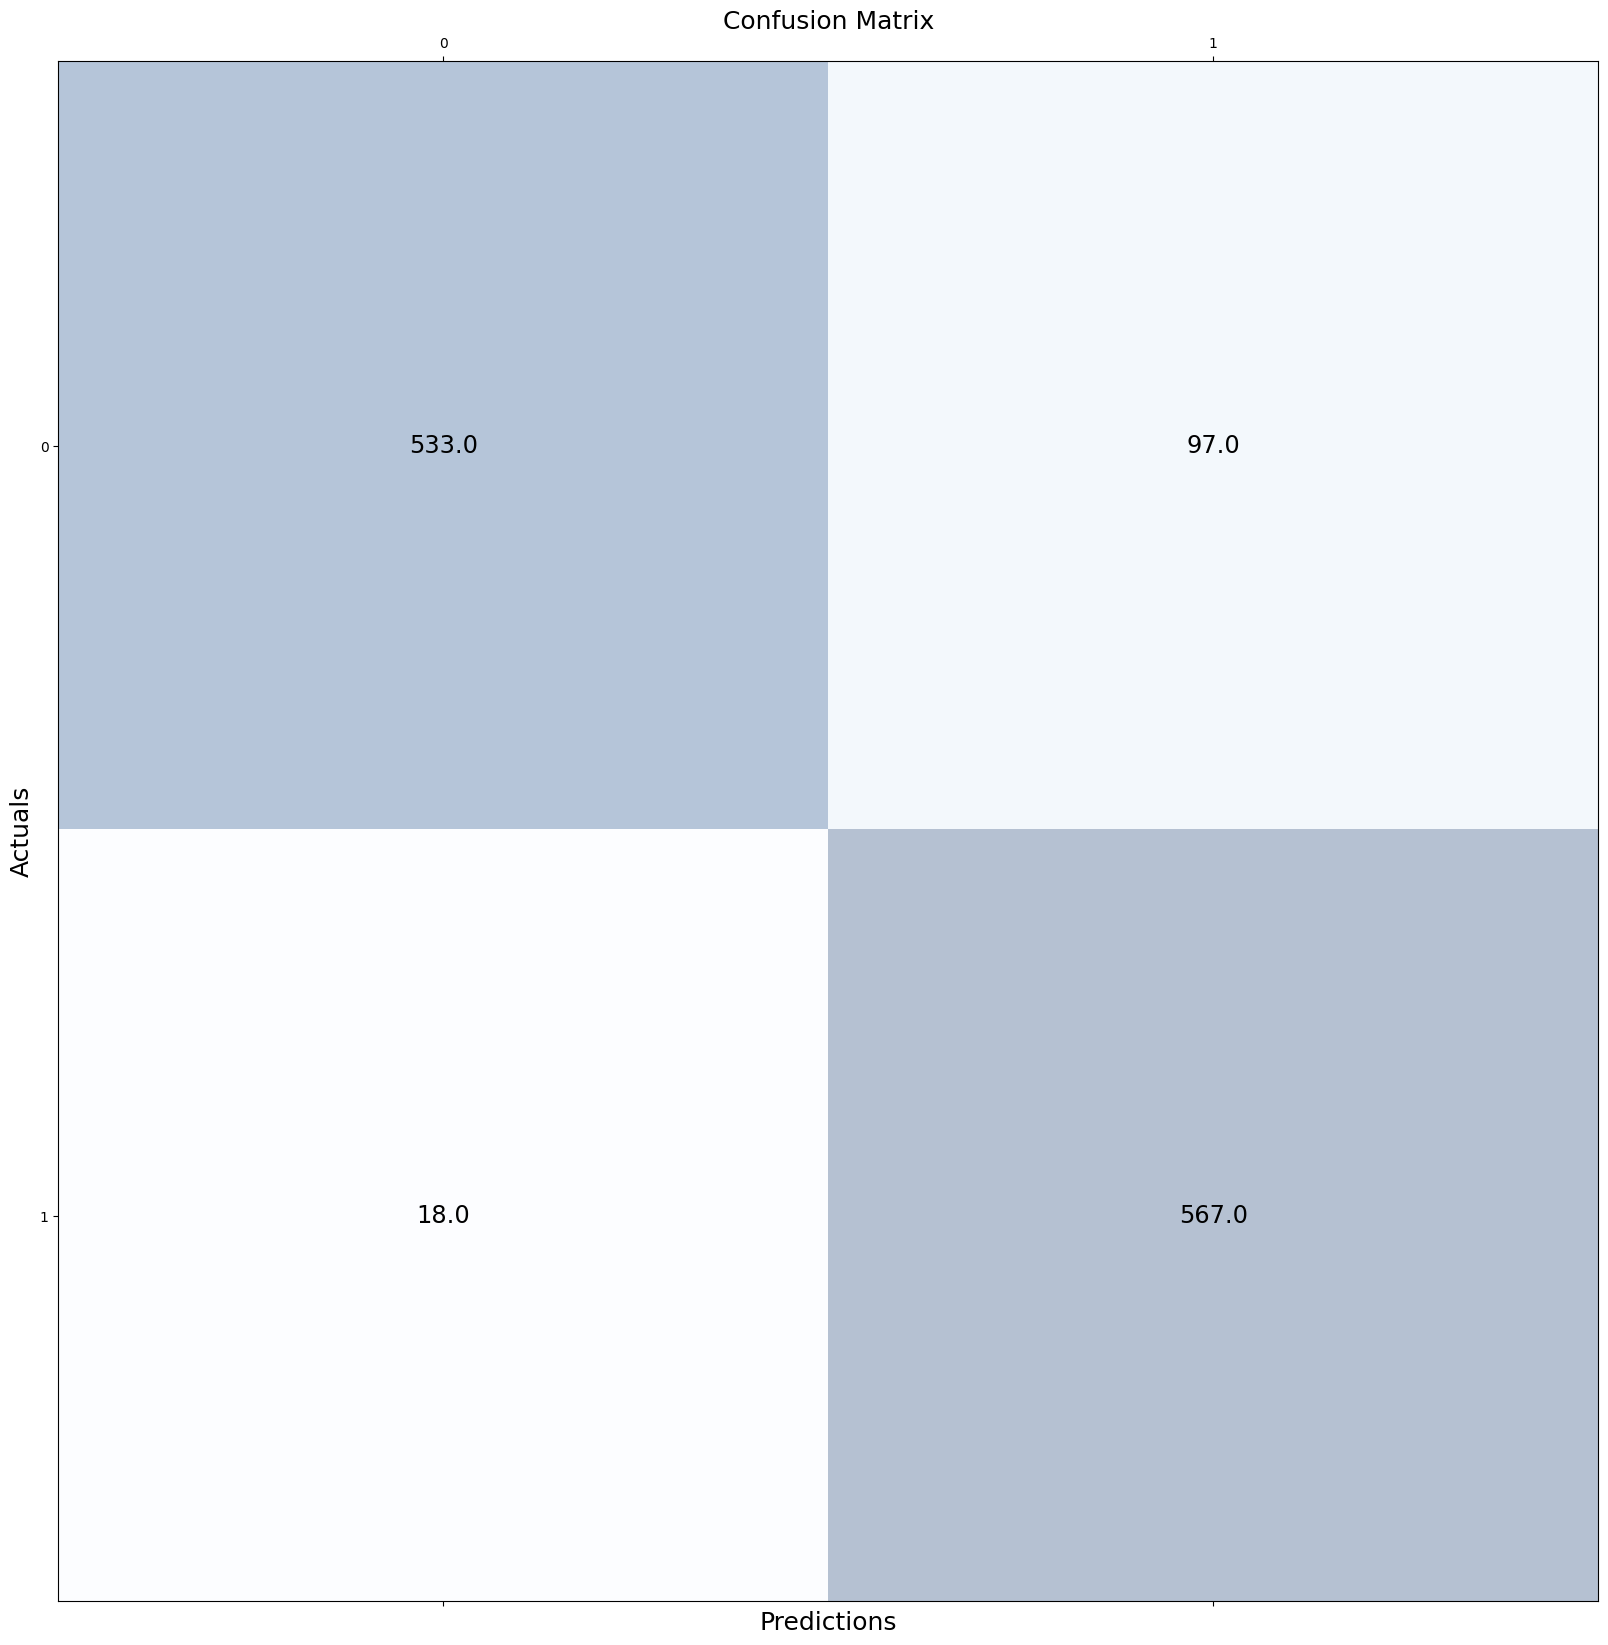

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()